# Korelace časových řad napříč regiony
Některé datové sady mají málo zajímavou vlastní strukturu, ale mohlo by být zajímavé porovnat jejich vliv na TFR napříč regiony.
Můžeme tak zjistit, že v zemi, kde se hodnota nějaké veličiny relativně liší od hodnot stejné veličiny v ostatních zemích, je jiné i TFR.

## Načtení dat
Použijeme data z World Bank a Eurostat.

In [7]:
import pandas as pd
import numpy as np
import world_bank_data as wb
import datetime

dataset_props = {
    'SP.DYN.TFRT.IN': {
        'id': 'tfr',
        'name': 'Total fertility rate',
        'description': 'Počet dětí, které by žena mohla mít, kdyby po celý její život platily hodnoty plodnosti podle věku pro daný rok.',
        'unit': 'počet dětí'
    },
    'SL.TLF.CACT.FE.ZS': {
        'id': 'lfp_female',
        'name': 'Participace žen 15+ v pracovním procesu',
        'description': 'Podíl ekonomicky aktivních žen ve věku 15 a více let (odhad ILOSTAT)',
        'unit': '%'
    },
    'SH.STA.SUIC.P5': {
        'id': 'suicide_mortality_rate',
        'name': 'Sebevražednost',
        'description': 'Hrubý počet sebevražd na 100000 obyvatel (WHO)',
        'unit': 'počet sebevražd'
    }
}

regions = [
    'AUT',
    'BEL',
    'BGR',
    'HRV',
    'CYP',
    'CZE',
    'DNK',
    'EST',
    'FIN',
    'FRA',
    'DEU',
    'GRC',
    'HUN',
    'IRL',
    'ITA',
    'LVA',
    'LTU',
    'LUX',
    'MLT',
    'NLD',
    'POL',
    'PRT',
    'ROU',
    'SVK',
    'SVN',
    'ESP',
    'SWE',
    'NOR',
    'GBR'
]

datasets = {}
for dataset_id in dataset_props:
    # Collect data since 1980 until now
    year = datetime.date.today().strftime("%Y")
    series = wb.get_series(dataset_id, date='1980:%s' % year, id_or_value='id', simplify_index=True)

    # Process dataset for each selected region
    per_region = {}

    for region in regions:
        data = series[region]

        # Strip NaNs
        index = data.index
        start = 0
        while start <= len(index) - 1:
            if not pd.isnull(data[index[start]]):
                break
            start = start + 1
        end = len(index) - 1
        while end >= 0:
            if not pd.isnull(data[index[end]]):
                break
            end = end - 1
        data = data.iloc[start:(end + 1)] # Last index is exclusive

        # Compute intermediary missing values using interpolation
        data = data.interpolate()

        if data.size < 3:
            print('Skipping %s for %s' % (dataset_id, region))

        per_region[region] = {
            'data': data
        }

    datasets[dataset_id] = per_region

tfr = datasets.pop('SP.DYN.TFRT.IN')

# Eurostat

# API to fetch the datasets from
api = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/%s?format=TSV'

# Regions to collect the datasets for
# Eurostat country codes along with codes used here
eurostat_regions = {
    'AT': 'AUT',
    'BE': 'BEL',
    'BG': 'BGR',
    'HR': 'HRV',
    'CY': 'CYP',
    'CZ': 'CZE',
    'DK': 'DNK',
    'EE': 'EST',
    'FI': 'FIN',
    'FR': 'FRA',
    'DE': 'DEU',
    'EL': 'GRC',
    'HU': 'HUN',
    'IE': 'IRL',
    'IT': 'ITA',
    'LV': 'LVA',
    'LT': 'LTU',
    'LU': 'LUX',
    'MT': 'MLT',
    'NL': 'NLD',
    'PL': 'POL',
    'PT': 'PRT',
    'RO': 'ROU',
    'SK': 'SVK',
    'SI': 'SVN',
    'ES': 'ESP',
    'SE': 'SWE',
    'NO': 'NOR',
    'UK': 'GBR'
}

# Datasets to collect along with their metadata
dataset_props = {
    'DEMO_NSINAGEC': [
        {
            'id': 'first_marriages_women',
            'name': 'První sňatky žen',
            'description': 'Počet poprvé se vdávajících žen',
            'unit': 'počet sňatků',
            'filter': {
                'sex': 'F',
                'age': 'TOTAL'
            },
        },
        {
            'id': 'first_marriages_men',
            'name': 'První sňatky mužů',
            'description': 'Počet poprvé se ženících mužů',
            'unit': 'počet sňatků',
            'filter': {
                'sex': 'M',
                'age': 'TOTAL'
            },
        },
    ],
    'EDUC_UOE_PERD03': [
        {
            'id': 'teachers_women_ed1',
            'name': 'Podíl žen mezi vyučujícími prvního stupně',
            'description': 'Procento zastoupení žen mezi vyučujícími prvního stupně',
            'unit': '%',
            'filter': {
                'isced11': 'ED1'
            }
        },
        {
            'id': 'teachers_women_ed3',
            'name': 'Podíl žen mezi vyučujícími středního vzdělání',
            'description': 'Procento zastoupení žen mezi vyučujícími středního vzdělání',
            'unit': '%',
            'filter': {
                'isced11': 'ED3'
            }
        }
    ],
    'YTH_DEMO_030': [
        {
            'id': 'age_when_leaving_parents_men',
            'name': 'Průměrný věk osamostatnění potomků - mužů',
            'description': 'Odhadovaný průměrný věk, kdy mladí dospělí opouštějí rodičovskou domácnost',
            'unit': 'věk',
            'filter': {
                'sex': 'M',
            }
        },
        {
            'id': 'age_when_leaving_parents_women',
            'name': 'Průměrný věk osamostatnění potomků - žen',
            'description': 'Odhadovaný průměrný věk, kdy mladí dospělí opouštějí rodičovskou domácnost',
            'unit': 'věk',
            'filter': {
                'sex': 'F',
            }
        }
    ]
}

def strip_nans(data):
    """Remove leading and trailing rows with missing values"""

    index = data.index

    start = 0
    while start <= len(index) - 1:
        if not pd.isnull(data[index[start]]):
            break
        start = start + 1

    end = len(index) - 1
    while end >= 0:
        if not pd.isnull(data[index[end]]):
            break
        end = end - 1
    
    return data.iloc[start:(end + 1)] # Last index is exclusive

for eurostat_id in dataset_props:
    data = pd.read_csv(api % eurostat_id, sep='\t')

    # Prepare data for filtering

    # Split leading column into separate columns
    leading_col = data.columns[0]
    leading_cols = data.columns[0].split(sep='\\')[0].split(sep=',')
    data[leading_cols] = pd.DataFrame(data[leading_col].apply(lambda x: x.split(sep=',')).to_list(), index=data.index)
    data.drop(leading_col, axis=1, inplace=True)

    # Replace ':' followed by optional flags with NaN
    data.replace(regex=':.*', value=np.NaN, inplace=True)

    # Strip trailing whitespace from column names
    data.rename(mapper=lambda x: x.strip(), axis=1, inplace=True)

    # print(data.head(10))

    # Filter out datasets
    for dataset in dataset_props[eurostat_id]:
        datasets[dataset['id']] = {}

        filtered_data = pd.DataFrame(data)
        for filter_by in dataset['filter']:
            filtered_data = filtered_data[data[filter_by] == dataset['filter'][filter_by]]
        
        # Extract per-country data
        for region in eurostat_regions:
            region_data = filtered_data[data['geo'] == region]

            # Add empty series even when there's no data to simplify grouping by year
            if region_data.size == 0: 
                datasets[dataset['id']][eurostat_regions[region]] = {
                    'data': pd.Series(name=dataset['id']).index.rename('Year')
                }
                continue
            
            # Create Series without the values used for filtering
            region_data = region_data.transpose()
            region_data.drop(index=leading_cols, inplace=True)
            region_data = region_data[region_data.columns[0]].squeeze()

            # Strip flags and trailing spaces from the values
            region_data = region_data.apply(lambda x: str(x).split(sep=' ')[0]).astype(np.float64)

            # Strip leading and trailing NaNs and interpolate intermediary missing values
            region_data = strip_nans(region_data)
            region_data = region_data.interpolate()

            region_data.index.rename('Year', inplace=True)
            region_data.name = dataset['id']

            datasets[dataset['id']][eurostat_regions[region]] = {
                'data': region_data
            }                

/tmp/ipykernel_16387/3775800029.py:248: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[data[filter_by] == dataset['filter'][filter_by]]
/tmp/ipykernel_16387/3775800029.py:252: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_data = filtered_data[data['geo'] == region]
/tmp/ipykernel_16387/3775800029.py:252: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_data = filtered_data[data['geo'] == region]
/tmp/ipykernel_16387/3775800029.py:252: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_data = filtered_data[data['geo'] == region]
/tmp/ipykernel_16387/3775800029.py:252: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_data = filtered_data[data['geo'] == region]
/tmp/ipykernel_16387/3775800029.py:252: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  region_da

## Korelace průměrných hodnot
Výpočítáme průměrnou hodnotu ukazatelů pro všechny regiony, tu pak porovnáme.

In [8]:
# TFR
all = pd.DataFrame(data['data'] for data in tfr.values())
all.reset_index(inplace=True)
all.drop(columns=['index'], inplace=True)
mean = all.mean()
mean.name = 'SP.DYN.TFRT.IN'
tfr['ALL'] = {
    'data': mean
}

# Others
for dataset_id in datasets:
    all = pd.DataFrame(data['data'] for data in datasets[dataset_id].values())
    all.reset_index(inplace=True)
    all.drop(columns=['index'], inplace=True)
    mean = all.mean()
    mean.name = dataset_id
    datasets[dataset_id]['ALL'] = {
        'data': mean
    }

In [9]:
from sklearn.linear_model import LinearRegression
from scipy import stats
import matplotlib.pyplot as plt

def plot_linear_regression(dataset_id, region_id, X, y, lag):
    model = LinearRegression()
    X_2d_array = np.asarray(X).reshape(-1, 1)
    model.fit(X_2d_array, y)
    pred = model.predict(X_2d_array)

    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(4)
    fig.suptitle(dataset_id + ' in ' + region_id + ' with lag ' + str(lag))
    plt.subplot(1, 2, 1)
    plt.plot(X.values)
    ax2 = plt.twinx()
    ax2.plot(y.values, color='orange')
    plt.autoscale()
    plt.subplot(1, 2, 2)
    plt.plot(X, pred, color='r')
    plt.scatter(X, y)
    plt.show()

def linear_regression(X, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

    return {
        'correlation': True if p_value <= 0.05 else False,
        'linear_regression': {
            'slope': slope,
            'intercept': intercept,
            'p_value': p_value,
            'std_err': std_err
        },
        'pearson_product_moment_correlation': {
            'r_value': r_value
        }
    }

def join(tfr, other, dataset_id):
    join = pd.merge(
        tfr,
        other,
        on='Year',
        how='inner')
    X = join['SP.DYN.TFRT.IN']
    y = join[dataset_id]
    return X, y

def process_linear_regression(dataset_id, region_id, tfr, other):
    X, y = join(tfr, other, dataset_id)

    result = linear_regression(X, y)
    datasets[dataset_id][region_id]['relation'] = result

    if result['correlation']:
        plot_linear_regression(dataset_id, region_id, X, y, 0)
        print(result)

Raw


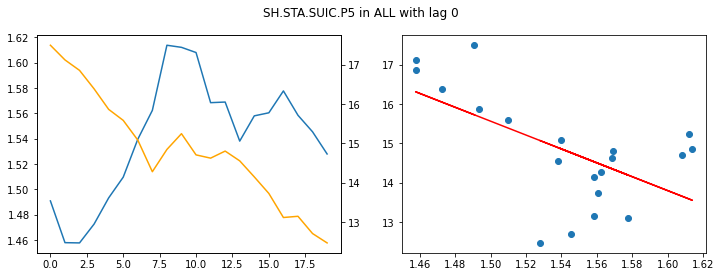

{'correlation': True, 'linear_regression': {'slope': -17.639459839023854, 'intercept': 42.021757764816215, 'p_value': 0.005822338107591819, 'std_err': 5.640684389237367}, 'pearson_product_moment_correlation': {'r_value': -0.5933254460141519}}


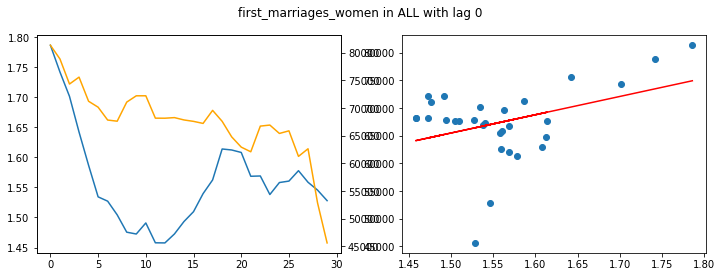

{'correlation': True, 'linear_regression': {'slope': 32936.527334207494, 'intercept': 16074.397027790787, 'p_value': 0.03601107796812709, 'std_err': 14952.498822425396}, 'pearson_product_moment_correlation': {'r_value': 0.3843107976487733}}


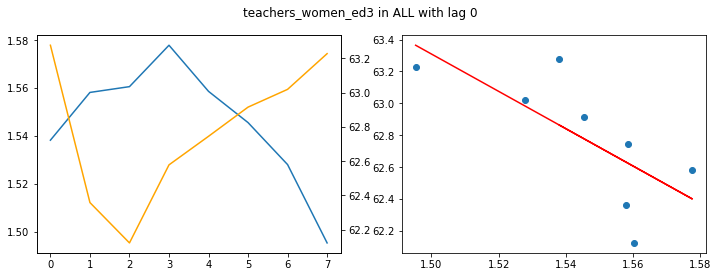

{'correlation': True, 'linear_regression': {'slope': -11.714192197166549, 'intercept': 80.88070020810105, 'p_value': 0.04257608592725235, 'std_err': 4.5655477171884575}, 'pearson_product_moment_correlation': {'r_value': -0.7233082530945545}}
Differenced


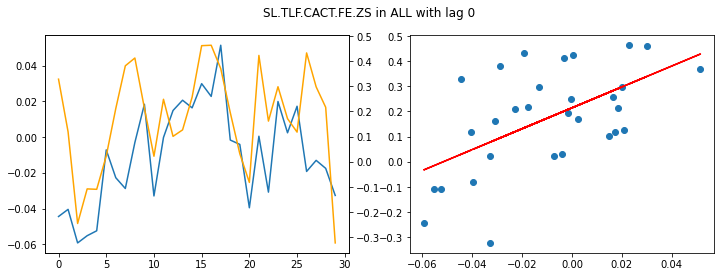

{'correlation': True, 'linear_regression': {'slope': 4.1573753535765885, 'intercept': 0.21417577466222543, 'p_value': 0.0010264062652520836, 'std_err': 1.1346529967528567}, 'pearson_product_moment_correlation': {'r_value': 0.5692790869895624}}


In [10]:
print('Raw')
for dataset_id in datasets:
    process_linear_regression(dataset_id, 'ALL', tfr['ALL']['data'], datasets[dataset_id]['ALL']['data'])
print('Differenced')
for dataset_id in datasets:
    process_linear_regression(dataset_id, 'ALL', tfr['ALL']['data'].diff().iloc[1:], datasets[dataset_id]['ALL']['data'].diff().iloc[1:])

Bylo nalezena několik málo korelací při porovnávání jak direfencovaných, tak původních řad.

## Lineární závislost v jednotlivých časech
Vytvoříme model sestávající z lineárních závislostí mezi dvojicemi TFR - vysvětlující proměnná v každém roce, tedy cross-sectional korelace.

Výsledkem bude graf korelace měnící se v čase.
Pokud bude hodnota po většinu času dostatečně vysoká, lze prohlásit, že mezi veličinami napříč reigony existuje vztah.

Následující grafy tedy čteme tak, že oranžová křivka odpovídá vývoji p-hodnot, červená vývoji korelačního koeficientu.
Body procházející `x = 0` jsou zelené, pokud jsou hodnoty v daném čase přijaty jako dostatečně silné tvrzení o korelaci, červené v opačném případě.

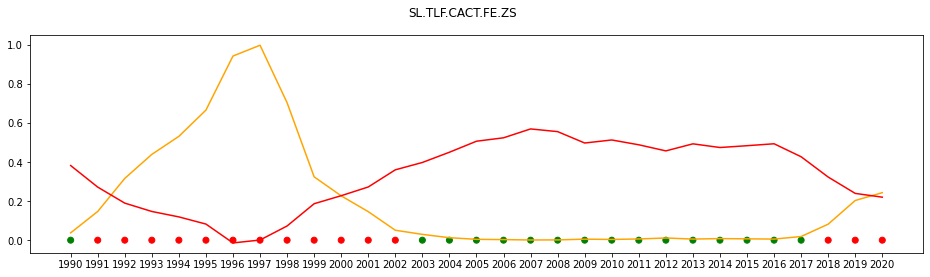

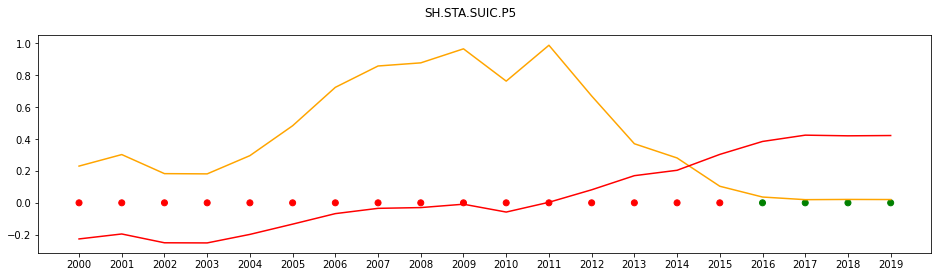

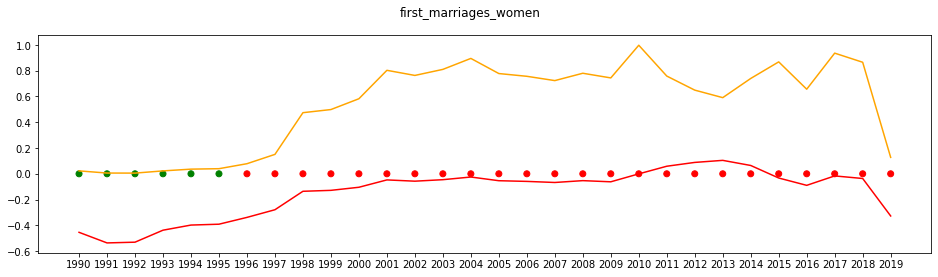

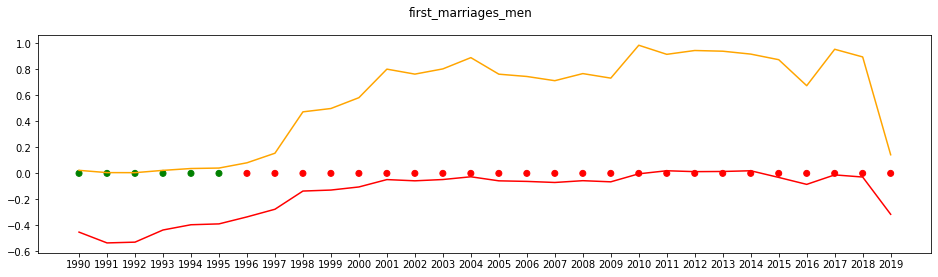

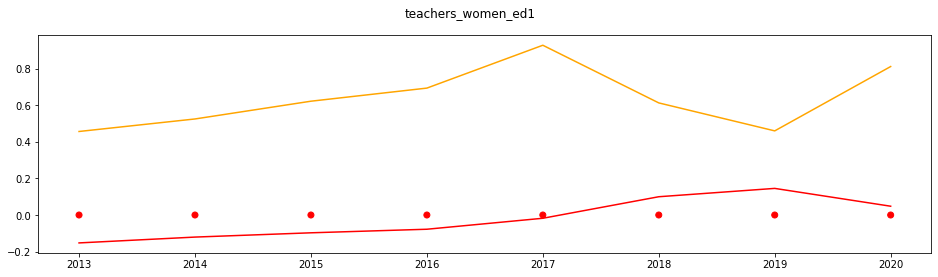

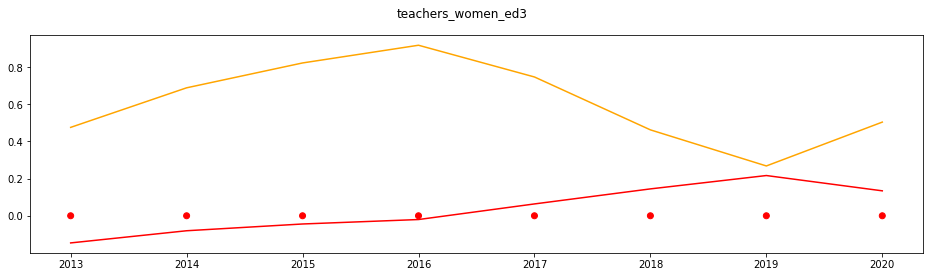

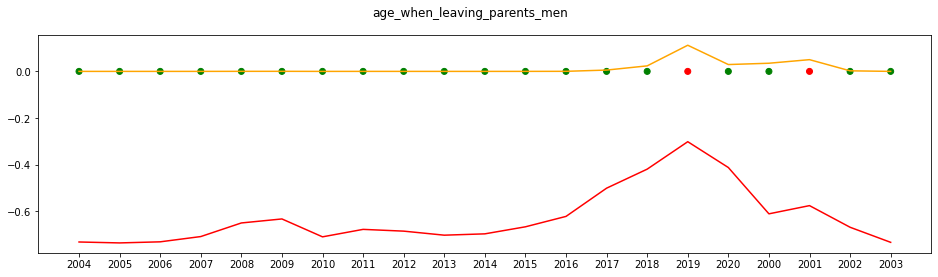

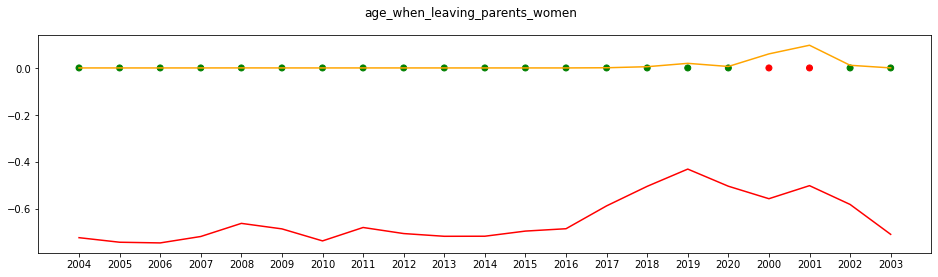

In [11]:
groups = {}

# TFR
tfr_all = pd.DataFrame(data['data'] for data in tfr.values())
tfr_all.reset_index(inplace=True)
tfr_all.drop(columns=['index'], inplace=True)

# Others
for dataset_id in datasets:
    all = pd.DataFrame(data['data'] for data in datasets[dataset_id].values())
    all.reset_index(inplace=True)
    all.drop(columns=['index'], inplace=True)
    # Test for sufficient number of regions available when in production

    groups[dataset_id] = {}
    for column in all.columns:
        if column in tfr_all.columns:
            # Add explanatory values for each region
            series = pd.Series(all[column])
            # Set index to the corresponding TFR values
            series.index = tfr_all[column]
            # Remove countries for which the value is missing
            series.dropna(inplace=True)
            groups[dataset_id][column] = series

# Analyze each group
for dataset_id in groups:
    # Linear regression for each year
    p_values = {}
    r_values = {}
    for year in groups[dataset_id]:
        result = linear_regression(groups[dataset_id][year].index, groups[dataset_id][year].values)
        p_values[year] = result['linear_regression']['p_value']
        r_values[year] = result['pearson_product_moment_correlation']['r_value']
    
    fig = plt.figure()
    fig.set_figwidth(16)
    fig.set_figheight(4)
    plt.suptitle(dataset_id)
    plt.plot(p_values.keys(), p_values.values(), color='orange')
    plt.plot(p_values.keys(), r_values.values(), color='red')
    plt.scatter(p_values.keys(), [0 for i in range(0, len(p_values))], c=[('g' if p_values[i] <= 0.05 else 'r') for i in p_values.keys()])
    plt.show()

Z grafů je patrné, že u prvního ukazatele existuje korelace napříč zeměmi mezi lety 2003 a 2017, u posledních dvou pak vidíme korelaci téměř po celou dobu, za kterou jsou dostupná data.
